In [1]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import os
import json
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
DATA_PATH = "../../data"

## Start with Anupam's list of materials

In [3]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [4]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

array([ 0.,  0.,  0.,  0., 28., 26.,  9., 12., 11., 11., 12.,  3.,  2.,
        2.,  1.,  8.,  5.,  9., 19., 11., 16., 15., 13., 16., 17., 23.,
       12., 15., 29., 24.,  0.,  0.,  0.,  0., 42., 10., 15.,  5.,  4.,
       18., 16.,  3.,  2.,  2.,  2.,  8.,  6., 12., 18., 12., 20., 19.,
       10., 20., 16., 22., 12., 14., 19., 23.])

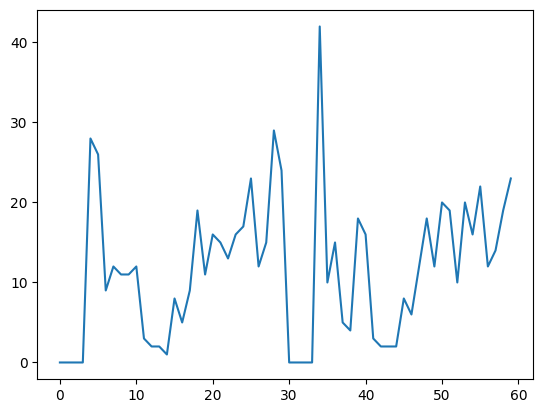

In [6]:
def calc_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    k_branches = [k_branches[0], k_branches[-1]]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]
        # print(i, branch_energies)
        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range)
        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint
    

fp = calc_fingerprint("2dm-1", 60)
plt.plot(fp)
fp

In [7]:
fingerprint_length = 60
finger_print_array = np.zeros([len(flat_df), fingerprint_length])

In [8]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :] = calc_fingerprint(material_id, fingerprint_length)

print(finger_print_array)

0 / 2005
100 / 2005
200 / 2005
300 / 2005
400 / 2005
500 / 2005
600 / 2005
700 / 2005
800 / 2005
900 / 2005
1000 / 2005
1100 / 2005
1200 / 2005
1300 / 2005
1400 / 2005
1500 / 2005
1600 / 2005
1700 / 2005
1800 / 2005
1900 / 2005
2000 / 2005
[[42.  0.  0. ...  0.  0.  0.]
 [ 0. 42. 19. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  7. 14. ... 15.  0.  0.]
 [79. 67. 64. ...  7.  6.  0.]
 [ 0.  0.  0. ...  7.  0.  0.]]


In [23]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,53,54,55,56,57,58,59
ID,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,...,50.0,17.0,0.0,0.0,0.0,0.0,0.0
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,...,58.0,84.0,61.0,7.0,0.0,0.0,0.0
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,...,37.0,22.0,2.0,0.0,0.0,0.0,0.0
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,...,106.0,94.0,111.0,33.0,0.0,0.0,0.0


In [24]:
#check for NaNs 
np.isnan(finger_print_array).sum()

0

In [25]:
df.isna().sum()[ df.isna().sum() != 0 ]

exfoliation_eg     606
decomp_eng          47
B                   10
C                 1124
D                 1752
E                 2005
F                 2005
dtype: int64

In [29]:
# save df
df.to_csv("materials_data_2_k_branches_fingerprint.csv")

## Clustering

In [8]:
df = pd.read_csv("materials_data_2_k_branches_fingerprint.csv", index_col="ID")
fingerprint_length = 60
fingerprint_cols = [str(i) for i in range(fingerprint_length)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=5, min_samples=5, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64), array([1701,   10,   10,    6,    8,    9,   16,  240,    5], dtype=int64))


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,54,55,56,57,58,59,labels
ID,,,,,,,,,,,,,,,
2dm-2600,Ga2S3,A2B3,1,4,4,0.96402,bottom-up,...,172.0,157.0,142.0,0.0,0.0,0.0,1
2dm-2649,In2S3,A2B3,1,4,4,0.98343,bottom-up,...,126.0,167.0,174.0,144.0,19.0,0.0,1
2dm-2658,Ga2Se3,A2B3,1,4,4,0.97087,bottom-up,...,165.0,164.0,87.0,0.0,0.0,0.0,1
2dm-2699,In2Se3,A2B3,1,4,4,0.92713,bottom-up,...,157.0,149.0,171.0,76.0,0.0,0.0,1
2dm-2838,Tl2Se3,A2B3,1,4,4,0.89736,bottom-up,...,126.0,150.0,162.0,29.0,0.0,0.0,1
2dm-2860,In2Se3,A2B3,1,4,4,0.95714,bottom-up,...,165.0,170.0,161.0,8.0,0.0,0.0,1
2dm-2898,Ga2Te3,A2B3,1,4,4,0.92116,bottom-up,...,164.0,171.0,167.0,0.0,0.0,0.0,1
2dm-2918,Ga2Te3,A2B3,1,4,4,0.92796,bottom-up,...,178.0,185.0,114.0,0.0,0.0,0.0,1
2dm-2931,Tl2Se3,A2B3,1,4,4,0.93519,bottom-up,...,129.0,120.0,174.0,83.0,0.0,0.0,1


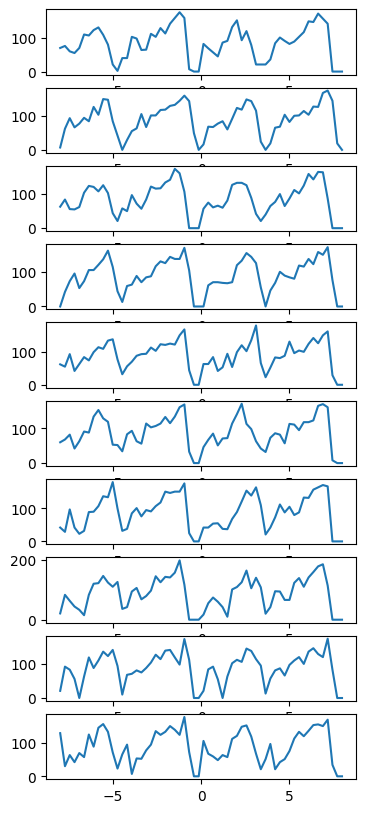

In [31]:
label = 1
num_plots = len(df[df.labels==label])

fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

for i, index in enumerate(df[df.labels==label].index):
    # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
    ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])

plt.show()

## T-SNE Plot

In [5]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.248s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 79.345463
[t-SNE] Computed conditional probabilities in 0.143s
[t-SNE] Iteration 50: error = 76.5761642, gradient norm = 0.0005015 (50 iterations in 0.484s)
[t-SNE] Iteration 100: error = 75.8610916, gradient norm = 0.0058134 (50 iterations in 0.591s)
[t-SNE] Iteration 150: error = 75.6591949, gradient norm = 0.0001388 (50 iterations in 0.515s)
[t-SNE] Iteration 200: error = 75.6559296, gradient norm = 0.0002449 (50 iterations in 0.548s)
[t-SNE] Iteration 250: error = 75.6379166, gradient norm = 0.0006697 (50 iterations in 0.566s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.637917
[t-SNE] Iteration 300: err

[t-SNE] Iteration 4150: error = 1.4098800, gradient norm = 0.0001808 (50 iterations in 0.598s)
[t-SNE] Iteration 4200: error = 1.4098500, gradient norm = 0.0001549 (50 iterations in 0.772s)
[t-SNE] Iteration 4250: error = 1.4098127, gradient norm = 0.0001654 (50 iterations in 0.564s)
[t-SNE] Iteration 4300: error = 1.4097426, gradient norm = 0.0001668 (50 iterations in 0.517s)
[t-SNE] Iteration 4350: error = 1.4097393, gradient norm = 0.0002210 (50 iterations in 0.558s)
[t-SNE] Iteration 4400: error = 1.4097233, gradient norm = 0.0002203 (50 iterations in 0.546s)
[t-SNE] Iteration 4450: error = 1.4096727, gradient norm = 0.0001836 (50 iterations in 0.571s)
[t-SNE] Iteration 4500: error = 1.4096150, gradient norm = 0.0001638 (50 iterations in 0.513s)
[t-SNE] Iteration 4550: error = 1.4096009, gradient norm = 0.0001815 (50 iterations in 0.521s)
[t-SNE] Iteration 4600: error = 1.4095697, gradient norm = 0.0002796 (50 iterations in 0.554s)
[t-SNE] Iteration 4650: error = 1.4095473, gradien

[t-SNE] Iteration 8500: error = 1.4081957, gradient norm = 0.0001092 (50 iterations in 0.601s)
[t-SNE] Iteration 8550: error = 1.4081709, gradient norm = 0.0001624 (50 iterations in 0.573s)
[t-SNE] Iteration 8600: error = 1.4081686, gradient norm = 0.0001390 (50 iterations in 0.496s)
[t-SNE] Iteration 8650: error = 1.4082170, gradient norm = 0.0001122 (50 iterations in 0.514s)
[t-SNE] Iteration 8700: error = 1.4081880, gradient norm = 0.0001206 (50 iterations in 0.510s)
[t-SNE] Iteration 8750: error = 1.4081502, gradient norm = 0.0002315 (50 iterations in 0.521s)
[t-SNE] Iteration 8800: error = 1.4081495, gradient norm = 0.0001187 (50 iterations in 0.556s)
[t-SNE] Iteration 8850: error = 1.4082024, gradient norm = 0.0001511 (50 iterations in 0.522s)
[t-SNE] Iteration 8900: error = 1.4082007, gradient norm = 0.0001285 (50 iterations in 0.498s)
[t-SNE] Iteration 8950: error = 1.4081782, gradient norm = 0.0001438 (50 iterations in 0.609s)
[t-SNE] Iteration 9000: error = 1.4080849, gradien

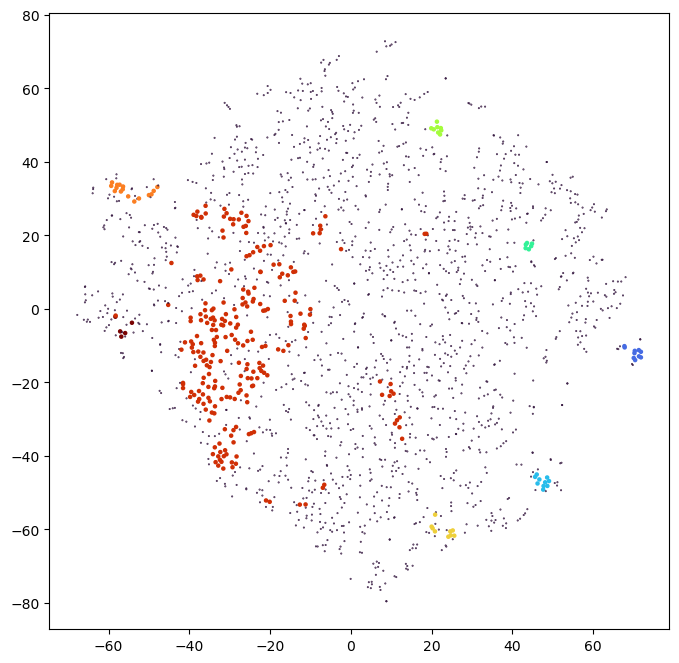

In [7]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")